In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install ipympl
!pip install seaborn
!pip install pyarrow
!pip install scipy
!pip install polars
!pip install openpyxl

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import bootstrap
import scipy.stats as stats
from scipy.stats import mannwhitneyu

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import polars as pl
import warnings
import datetime

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.7f}'.format
np.random.seed(42)

In [3]:
def create_box_and_hist(data, column):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(4, 4), gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel(f'# {column}')
    ax_box.boxplot(data[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='orange'))
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    plt.tight_layout()
    plt.show()

def boot(data, column, stat, stat_label=''):
    rnd = 42
    res = bootstrap((data[column].values,), stat, confidence_level=0.9,
                    random_state=rnd, batch=1, n_resamples=20000)
    #fig, ax = plt.subplots()
    #ax.hist(res.bootstrap_distribution, bins=25)
    #ax.set_title('Bootstrap Distribution')
    #ax.set_xlabel(stat_label)
    #ax.set_ylabel('frequency')
    #plt.show()
    return res

def histo(df):
    df.hist()
    plt.tight_layout()
    plt.show()

def mannwhitu(column):
    statistic, p_value = mannwhitneyu(df_outliers[column], df[df.iso != -1 ][column], alternative='greater')
    print(f"Statistic for: {column}", statistic)
    print(f"p-value: for: {column}", p_value)
    print(f"")

def compare_sets(column):
    A = boot(df, column, np.mean)
    B = boot(df_outliers, column, np.mean)
    
    ax1 = plt.hist(A.bootstrap_distribution, bins=100, label='Non-Outliers')
    ax2 = plt.hist(B.bootstrap_distribution, bins=100, label='Outliers')
    
    plt.title(f'Comparing Final Set of Users for Feature: {column}')
    plt.legend(loc='upper center')

    plt.savefig(f'compare_{column}.png', bbox_inches='tight')
    plt.show()
    print(A.confidence_interval)
    print(B.confidence_interval)

In [4]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

In [5]:
dfreco = pl.read_parquet("recommendations.parquet")#.set_index('review_id')
#dfgame = pd.read_csv("games.csv")
#dfuser = pd.read_csv("users.csv")
#dfmeta = pd.read_json('games_metadata.json', lines=False)


In [6]:
original_user_count = len(dfreco)

In [7]:
dfreco.to_pandas().describe()

,app_id,helpful,funny,hours,user_id,review_id
count,"41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000","41,154,794.0000000"
mean,"603,272.3585402",3.2025669,1.0580709,100.6022378,"7,450,576.0049239","20,577,396.5000000"
std,"472,923.2816550",46.9364857,28.6706028,176.1675413,"4,010,685.0333110","11,880,365.8415090"
min,10.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
25%,"253,940.0000000",0.0000000,0.0000000,7.8000000,"4,287,256.0000000","10,288,698.2500000"
50%,"435,150.0000000",0.0000000,0.0000000,27.3000000,"7,546,445.5000000","20,577,396.5000000"
75%,"933,110.0000000",0.0000000,0.0000000,99.2000000,"10,968,770.7500000","30,866,094.7500000"
max,"2,253,290.0000000","36,212.0000000","28,109.0000000","1,000.0000000","14,306,063.0000000","41,154,793.0000000"


In [8]:
dfreco.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


In [9]:
# Summarize data to the user id level
df = dfreco.to_pandas().groupby('user_id').agg({'helpful':'sum', 'funny':'sum', 'app_id': 'nunique', 'is_recommended':'sum', 'hours':'sum'}).rename(columns={'app_id': 'products', 'is_recommended':'recommended'})

In [10]:
df.describe()

,helpful,funny,products,recommended,hours
count,"13,781,059.0000000","13,781,059.0000000","13,781,059.0000000","13,781,059.0000000","13,781,059.0000000"
mean,9.5639224,3.1597490,2.9863288,2.5618059,300.4315106
std,126.4814068,58.3653193,8.1180071,6.5223299,516.2289609
min,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000
25%,0.0000000,0.0000000,1.0000000,1.0000000,28.6000000
50%,0.0000000,0.0000000,1.0000000,1.0000000,114.6000000
75%,2.0000000,0.0000000,3.0000000,2.0000000,388.4000000
max,"70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","290,694.2000000"


In [11]:
# Max hours seems high, let's constrain to only hours that would fall within the date range of the platform life
data1 = datetime.datetime(2003, 1, 1, 0, 0, 0) #First Possible Launch of Steam
data2 = datetime.datetime.now() 

diff = data2 - data1
hours = diff.days * 24 + diff.seconds // 3600
df = df[df.hours <= hours]

# We do not want any users with any value less than or equal to 0
df = df[(df.helpful > 0)&(df.funny > 0)&(df.recommended > 0)&(df.recommended < df.products)&(df.products>10)]

In [12]:
features = ['products','helpful','funny', 'hours', 'recommended']
X = df[features].values

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]

In [13]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance with Hours")

,products,helpful,funny,hours,recommended
0,0.010706,0.109203,0.026837,0.993565,0.008263


In [14]:
features = ['products','helpful','funny', 'hours', 'recommended']
df[features].corr().style.background_gradient(cmap='coolwarm')

,products,helpful,funny,hours,recommended
products,1.000000,0.396414,0.153508,0.400030,0.904623
helpful,0.396414,1.000000,0.524337,0.216647,0.402085
funny,0.153508,0.524337,1.000000,0.139482,0.154581
hours,0.400030,0.216647,0.139482,1.000000,0.410345
recommended,0.904623,0.402085,0.154581,0.410345,1.000000


In [15]:
features = ['products','helpful','funny']
df[['products','helpful','funny']].corr().style.background_gradient(cmap='coolwarm')

,products,helpful,funny
products,1.000000,0.396414,0.153508
helpful,0.396414,1.000000,0.524337
funny,0.153508,0.524337,1.000000


In [16]:
X = df[features].values

pca = PCA(n_components=1, random_state=42)
pca_result = pca.fit_transform(X)

df['single_pca'] = pca_result[:,0]
#df['single_pca_sort'] = df.single_pca.abs()


In [17]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance without Hours")

,products,helpful,funny
0,0.023754,0.974939,0.221202


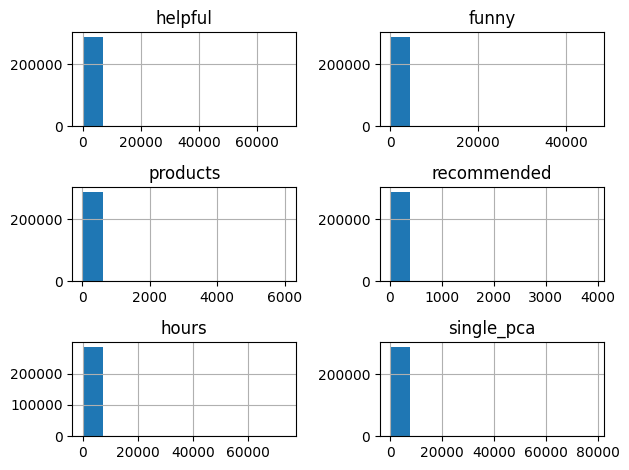

In [18]:
histo(df)


df['helpful_rat'] = df.helpful / df.products
df['funny_rat'] = df.funny / df.products
df['recommended_rat'] = df.recommended / df.products
df['hours_rat'] = df.hours / df.products

df = df[df['single_pca'] >= np.percentile(df['single_pca'].values, 95)]

In [19]:
df.describe()

,helpful,funny,products,recommended,hours,single_pca,helpful_rat,funny_rat,recommended_rat,hours_rat
count,"14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000","14,411.0000000"
mean,"1,802.3271806",509.7544931,78.5969745,60.7416557,"3,105.6997779","1,685.2921180",46.0398822,15.9601540,0.7910543,64.2465562
std,"2,473.5567539","1,035.5147216",141.7923214,100.2566828,"3,397.5597982","2,511.8860719",64.8184386,37.0794556,0.1612425,56.6453282
min,278.0000000,2.0000000,11.0000000,1.0000000,3.1000000,500.4726539,0.4546875,0.0061350,0.0084034,0.2583333
25%,822.0000000,90.0000000,22.0000000,17.0000000,"1,281.0500000",673.3429281,14.9651937,1.6018868,0.7142857,26.8691950
50%,"1,113.0000000",227.0000000,42.0000000,34.0000000,"2,289.1000000",981.8602778,29.0606061,4.8000000,0.8333333,48.2685714
75%,"1,796.0000000",569.0000000,86.0000000,69.0000000,"3,844.9000000","1,685.8488019",55.1583333,14.9305556,0.9142857,83.3424812
max,"70,096.0000000","46,186.0000000","6,045.0000000","3,920.0000000","73,729.9000000","78,372.3027083","2,116.0434783",999.7692308,0.9988675,889.8714286


In [20]:
X = df[features].values
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X)
scores = iso.decision_function(X)

df["iso"] = outliers
df["iso_score"]  = scores
df['type'] = df['iso'].apply(lambda x: "Outlier" if x == -1 else "Inlier")

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
sns_order = ['Outlier', 'Inlier']

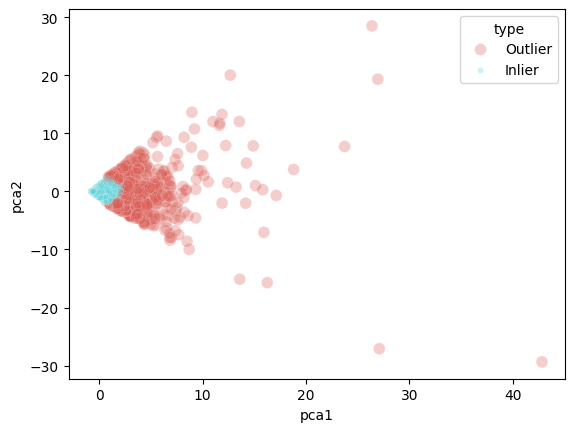

In [22]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)

df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="pca1", 
    y="pca2", 
    hue="type",
    hue_order = sns_order,
    legend=True,
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

In [23]:
pd.DataFrame(pca.components_, columns=features).style.set_caption("Feature Importance without Hours")

,products,helpful,funny
0,0.485670,0.691926,0.534194
1,0.746091,-0.009686,-0.665774


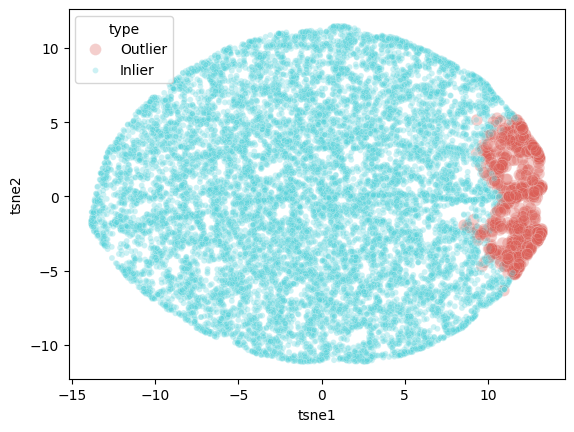

In [24]:
tsne = TSNE(n_components=2, perplexity=40, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X)

df['tsne1'] = tsne_results[:,0]
df['tsne2'] = tsne_results[:,1] 

sp = sns.scatterplot(
    data=df, 
    x="tsne1", 
    y="tsne2", 
    hue="type",
    hue_order = sns_order,
    legend="full",
    palette=sns.color_palette("hls", 2),
    size="type",
    size_order = sns_order,
    alpha=0.3
)

plt.show(sp)

In [25]:
df_outliers = df[df.iso == -1]
#df_outliers = df_outliers[df_outliers.hours <= hours]

cols = ['user_id', 'products','helpful','funny', 'hours', 'recommended', 'helpful_rat', 'funny_rat', 'recommended_rat', 'hours_rat']
df_outliers = df_outliers.sort_values(by='single_pca', ascending=False)#['products','helpful','funny', 'hours', 'recommended'], ascending=False)
df_outliers.reset_index(inplace=True)
df_outliers.index = np.arange(1, len(df_outliers)+1)
df_outliers.head()

,user_id,helpful,funny,products,recommended,hours,single_pca,helpful_rat,funny_rat,recommended_rat,hours_rat,iso,iso_score,type,pca1,pca2,tsne1,tsne2
1,5860500,70096,46186,129,107,"3,922.6000000","78,372.3027083",543.3798450,358.0310078,0.8294574,30.4077519,-1,-0.2385222,Outlier,42.8409852,-29.3703090,13.2389774,-2.2079482
2,8040965,65990,1132,1673,1633,"7,642.1000000","64,439.8549783",39.4441124,0.6766288,0.9760909,4.5679020,-1,-0.2358047,Outlier,23.7381718,7.7383734,13.2452192,0.7088842
3,9231134,53730,2310,1056,762,"7,558.6000000","52,733.0256386",50.8806818,2.1875000,0.7215909,7.1577652,-1,-0.2334562,Outlier,18.8028569,3.7822956,13.2397156,0.6434625
4,11446587,49721,1511,428,325,"12,392.4000000","48,632.8383081",116.1705607,3.5303738,0.7593458,28.9542056,-1,-0.1805623,Outlier,15.1180731,1.0071606,13.2270365,0.5830134
5,352264,48669,2929,23,22,313.8000000,"47,911.2463936","2,116.0434783",127.3478261,0.9565217,13.6434783,-1,-0.1500104,Outlier,14.1680575,-2.0315661,13.2217426,0.5460904


In [26]:
df_outliers[cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 1 to 721
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          721 non-null    int64  
 1   products         721 non-null    int64  
 2   helpful          721 non-null    int64  
 3   funny            721 non-null    int64  
 4   hours            721 non-null    float64
 5   recommended      721 non-null    int64  
 6   helpful_rat      721 non-null    float64
 7   funny_rat        721 non-null    float64
 8   recommended_rat  721 non-null    float64
 9   hours_rat        721 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 62.0 KB


In [27]:
df_outliers[cols].drop('user_id', axis=1).describe()

,products,helpful,funny,hours,recommended,helpful_rat,funny_rat,recommended_rat,hours_rat
count,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000,721.0000000
mean,350.9486824,"8,018.3717060","2,653.5977809","6,458.9732316",253.1816921,103.7338581,65.6675051,0.7939789,47.1008831
std,492.0252888,"7,597.4564366","3,495.8371075","7,802.3542258",331.3915718,187.0488414,120.4019733,0.1801944,57.7951043
min,11.0000000,472.0000000,4.0000000,141.1000000,1.0000000,0.4546875,0.0083160,0.0084034,0.8693522
25%,45.0000000,"3,093.0000000",516.0000000,"2,451.4000000",38.0000000,13.6857798,1.0827887,0.7265745,12.2226950
50%,197.0000000,"6,130.0000000","1,801.0000000","4,402.8000000",153.0000000,43.5392157,9.1284722,0.8385650,27.3743590
75%,493.0000000,"10,542.0000000","3,735.0000000","7,642.6000000",351.0000000,114.9444444,70.1320755,0.9252874,62.6035714
max,"6,045.0000000","70,096.0000000","46,186.0000000","73,729.9000000","3,920.0000000","2,116.0434783",999.7692308,0.9988675,512.0131944


In [28]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_outliers[cols].style.format(precision=2))

,user_id,products,helpful,funny,hours,recommended,helpful_rat,funny_rat,recommended_rat,hours_rat
1,5860500,129,70096,46186,3922.60,107,543.38,358.03,0.83,30.41
2,8040965,1673,65990,1132,7642.10,1633,39.44,0.68,0.98,4.57
3,9231134,1056,53730,2310,7558.60,762,50.88,2.19,0.72,7.16
4,11446587,428,49721,1511,12392.40,325,116.17,3.53,0.76,28.95
5,352264,23,48669,2929,313.80,22,2116.04,127.35,0.96,13.64
6,11451103,620,44896,4202,16059.40,563,72.41,6.78,0.91,25.90
7,5112758,4152,42745,3510,8404.20,3920,10.30,0.85,0.94,2.02
8,3963306,433,42050,1997,6437.20,387,97.11,4.61,0.89,14.87
9,8865664,879,39597,7905,8199.50,872,45.05,8.99,0.99,9.33
10,8568403,617,36180,2369,12589.70,462,58.64,3.84,0.75,20.40


In [29]:
features = ['products','helpful','funny', 'hours', 'recommended']
print(df_outliers[features].median()) 
print(df[features].median()) 

products        197.0000000
helpful       6,130.0000000
funny         1,801.0000000
hours         4,402.8000000
recommended     153.0000000
dtype: float64
products         42.0000000
helpful       1,113.0000000
funny           227.0000000
hours         2,289.1000000
recommended      34.0000000
dtype: float64


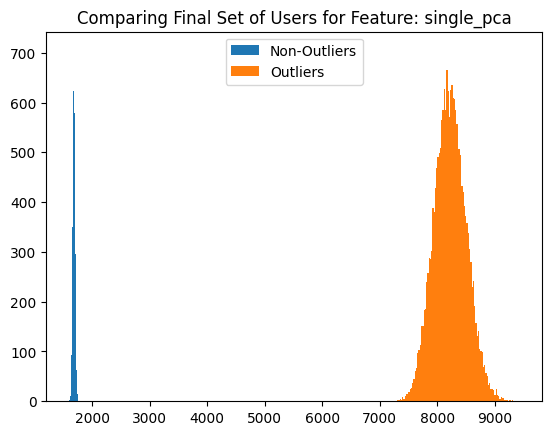

ConfidenceInterval(low=1653.016247571129, high=1721.2914564655134)
ConfidenceInterval(low=7793.885313355679, high=8728.166967521056)


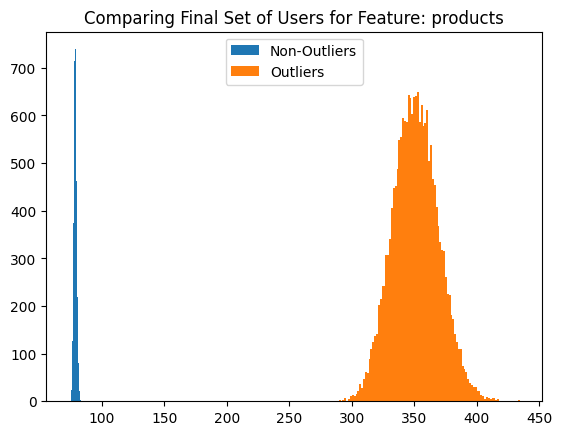

ConfidenceInterval(low=76.81174677730097, high=80.71648169794818)
ConfidenceInterval(low=322.9124423779639, high=383.75173370319004)


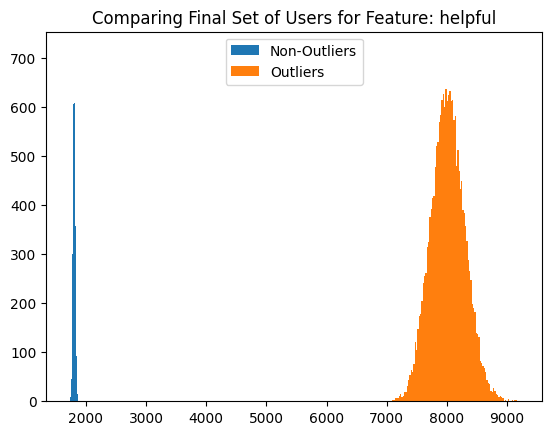

ConfidenceInterval(low=1770.6004527868097, high=1837.8495737219707)
ConfidenceInterval(low=7581.067558944828, high=8518.143141985654)


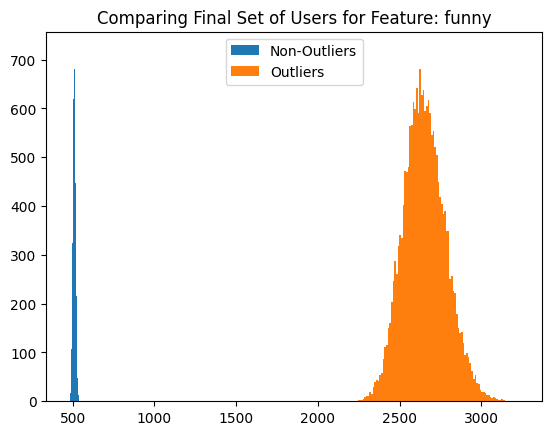

ConfidenceInterval(low=496.97502003941605, high=525.4327830512428)
ConfidenceInterval(low=2469.5742656852876, high=2909.2340012056884)


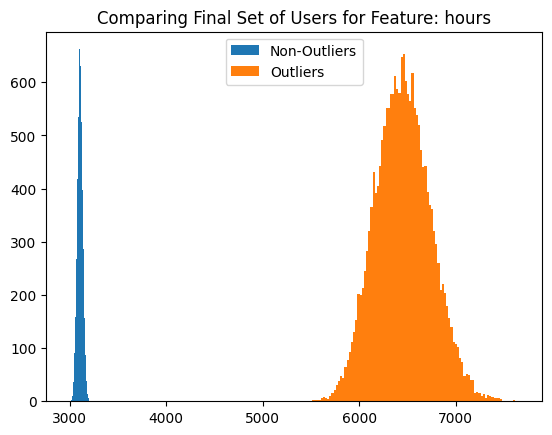

ConfidenceInterval(low=3060.211376334556, high=3153.6983337171814)
ConfidenceInterval(low=6030.438001795412, high=6990.559400169759)


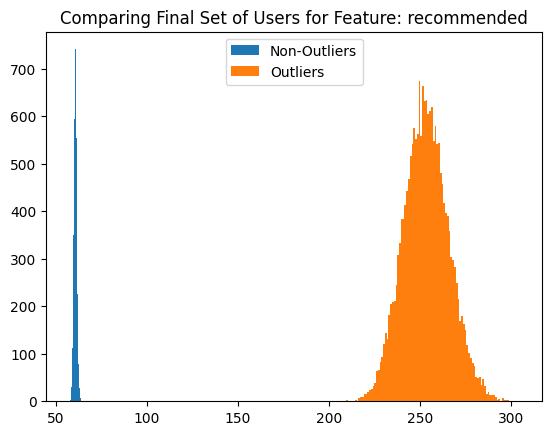

ConfidenceInterval(low=59.461129156151415, high=62.203810738379666)
ConfidenceInterval(low=234.0114383087295, high=275.39894287608286)


In [30]:
features = ['single_pca','products','helpful','funny','hours','recommended']
for f in features:
    compare_sets(f)


In [31]:
for f in features:
    mannwhitu(f)

Statistic for: single_pca 9260977.0
p-value: for: single_pca 0.0

Statistic for: products 7492679.5
p-value: for: products 2.5189809320455523e-122

Statistic for: helpful 9100473.5
p-value: for: helpful 0.0

Statistic for: funny 8298159.0
p-value: for: funny 8.929307251311806e-210

Statistic for: hours 7088713.5
p-value: for: hours 2.2716229204385626e-87

Statistic for: recommended 7533096.0
p-value: for: recommended 3.747550924095707e-126



In [32]:
print(f'Original user count: {original_user_count}')
print(f'User candidate count: {len(df)}')
print(f'Anomaly user count: {len(df_outliers)}')

Original user count: 41154794
User candidate count: 14411
Anomaly user count: 721


In [33]:
df_outliers.to_excel('recommendation_outliers.xlsx')